# Modeling and clustering

Для дальнейшей работы мы должны получить векторы сессий. Оставим за рамками исследования подбор модели и просто констатируем, что для получения вектора мы обучим модель word2vec по последовательностям event-ов. Так же за рамками мы оставим подбор параметров модели. В ходе экспериментов выяснилось, что на таких данных результаты моделей с кардинально отличающимися параметрами (например, размер вектора 10 против 200) практически не отличаются. Собственно, сам вектор сессии получается путем усреднения векторов ее токенов.

Кластеризовать мы будем непосредственно векторы сессии. Логично использовать векторы word2vec для вычисления косинусного расстояния между сессиями. Но, напомню, что цель исследования - разработка алгоритма для работы в высоконагруженных системах в условиях ограниченных мощностей, а построение матрицы расстояний размерностью несколько сот тысяч для многих клиентов точно не подходит для таких систем.

Для кластеризации мы используем KMeans, так как он крайне быстрый и хорошо работает с разреженными данными. Опять же за рамками остаются эксперименты с другими алгоритмами кластеризации.

In [11]:
import pandas as pd
import numpy as np
from itertools import groupby
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
dtype = {
    'time': 'str',
    'session_id': 'uint',
    'event': 'str',
}

In [3]:
data = pd.read_csv('data_with_events.csv', dtype=dtype)
data.head()

,time,session_id,event
0,2022-02-07 18:43:07.694,3059192787115454724,/
1,2022-02-07 18:43:12.379,3059192787115454724,/
2,2022-02-07 18:43:14.382,3059192787115454724,/view/theme/content/js
3,2022-02-07 18:43:17.314,3059192787115454724,/xhr/cart/
4,2022-02-07 18:43:17.330,3059192787115454724,/xhr/productsliders/


In [4]:
data = data.sort_values(['session_id', 'time']).reset_index(drop=True)

Преобразование сессий в последовательность токенов:

In [5]:
session_ids = []
sequences = []
for session_id, session in groupby(data.itertuples(), key=lambda x: x.session_id):
    session = list(session)
    session_ids.append(session_id)
    sequences.append(list(map(lambda x: x.event, session)))
session_ids = np.array(session_ids, dtype='uint')

Обучение модели и получение векторов сессии. На основе результатов предыдущего этапа длина сессии ограничивается 100 запросами.

In [6]:
model = Word2Vec(sequences, window=3, min_count=1, vector_size=10, epochs=10, sg=1)
vectors = []
for sequence in sequences:
    if sequence == []:
        vectors.append(np.zeros(model.vector_size))
    else:
        vectors.append(np.mean(model.wv[sequence[:100]], axis=0))
vectors = np.array(vectors)

In [7]:
vectors.shape

(167341, 10)

Выбор 10 тысяч случайных сессий для подбора количества кластеров и визуализации в 2-мерном пространстве.

In [8]:
rand_ids = np.random.randint(0, len(vectors), 10000)

Подбор кластеров будет осуществляться по оптимальной силуэтной метрике, либо по методу локтя. Если повезет - по обоим способам.

In [9]:
def kmeans_results(X):
    inertias = []
    sil_scores = []
    n_iter = range(2, 20)
    for i in tqdm(n_iter):
        kmeans = KMeans(n_clusters=i).fit(X)
        inertias.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(X, kmeans.labels_))
        
    plt.figure()
    plt.plot(n_iter, inertias, marker='o')
    plt.xticks(n_iter)
    plt.title('The elbow method')
    plt.grid(True)
    plt.show()
    
    plt.figure()
    plt.plot(n_iter, sil_scores, marker='o')
    plt.xticks(n_iter)
    plt.title('The silhouette coefficient method')
    plt.grid(True)
    plt.show()

  0%|          | 0/18 [00:00<?, ?it/s]

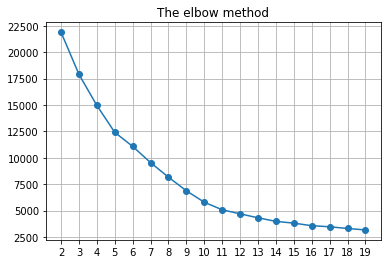

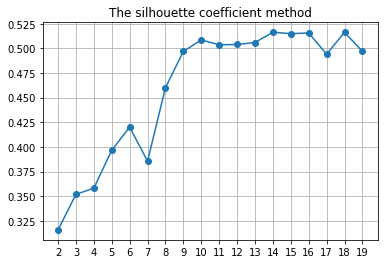

In [12]:
kmeans_results(vectors[rand_ids])

Не повезло, выберем 10 кластеров по силуэтной метрике

In [13]:
kmeans = KMeans(10, max_iter=1000, n_init=50)
kmeans.fit(vectors)

KMeans(max_iter=1000, n_clusters=10, n_init=50)

Для представления в 2-мерном пространстве используем TSNE. В качестве альтернативы рассматривался UMAP, но он оказался очень чувствителен к шуму, которого в данных очень много - это те самые короткие сессии из 1-5 запросов.

In [14]:
mapper = TSNE(n_components=2, perplexity=300)
X_emb = mapper.fit_transform(vectors[rand_ids])

/home/alexander/complete/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/alexander/complete/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Подготовим данные для визуализации.

In [15]:
clusters = pd.DataFrame(session_ids[rand_ids], columns=['session_id'])
clusters['cluster'] = kmeans.labels_[rand_ids]
clusters['x1'] = X_emb[:, 0]
clusters['x2'] = X_emb[:, 1]
clusters['session'] = clusters.session_id.apply(lambda x: '<br>'.join(data[data.session_id == x].event[:30].to_list()))

In [16]:
traffic = data[data.session_id.isin(clusters.session_id)]

In [17]:
def make_html_plot(clusters, traffic):
    fig = go.Figure()
    for cluster in sorted(clusters.cluster.unique()):
        cluster_slice = clusters[clusters.cluster == cluster]
        session_volume = cluster_slice.shape[0] / clusters.shape[0]
        traffic_volume = traffic[traffic.session_id.isin(cluster_slice.session_id)].shape[0] / traffic.shape[0]
        fig.add_trace(
            go.Scatter(
                x=cluster_slice.x1,
                y=cluster_slice.x2,
                mode='markers',
                text=cluster_slice.session,
                name=f"Cluster {cluster}.<br>Sessions volume {session_volume:.2%}<br>traffic_volume {traffic_volume:.2%}"
            )
        )
    fig.update_layout(
        width = 1000,
        height = 800,
        title = f"Clusters"
    )
    fig.update_yaxes(
        scaleanchor = "x",
        scaleratio = 1
    )
    return fig

На графике при наведении на точку будут отображены первые 30 запросов соотетствующей сессии.

In [18]:
fig = make_html_plot(clusters, traffic)

In [19]:
fig.write_html('clusters.html')

### Интерпретация результатов

Как видно, алгоритм хорошо справился с отдельно стоящими кластерами, которые представлены сессиями преимущественно из одного и того же event-а. Разные event-ы - разные кластеры. Наблюдется смешанное из 3 кластеров плотное скопление точек в центре, но если посмотреть на сессии каждого кластера, то становится очевидным, что разделение имеет логику. В первом (красном) кластере преобладает загрузка статики в сессиях, в третьем (фиолетовом) - загрузка контента, а в пятом (голубом) - запросы к корзине.

Для последующей экспертной оценки такие кластеры подходят